In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import shapely
%matplotlib inline

# Exploring Sydney

Previously we cleaned up Sydney data for OSM. The next step is to explore what is the most common street name for Sydney

In [5]:
streets = gpd.read_file("clean_streets_sydney.geojson")

Before finding what the most common *street name* is, i.e. the part before street or avenue, I am first finding the most common full street name. Partly because this is simple to do, so why not? Partly to check that my data is in a state to use.

In [6]:
streets.groupby("name").count()["id"].sort_values(ascending = False).head(10)

name
victoria road        197
pacific highway      191
princes highway      155
westlink m7          145
church street        137
m2 hills motorway    130
george street        127
windsor road         124
western motorway     119
parramatta road      117
Name: id, dtype: int64

Victoria Road is a little bit surprising, but not overly so. I can think of at least two Victoria Roads in Sydney - one of which is a major artery road. But Pacific Highway? Princes Highway? Westlink M7? There is definitely only one of each of these in Sydney. So what is wrong? 

Since I'm a good data scientist, I plot these to find out what is happening:

In [15]:
len(victoria_road), len(colour_list)

(197, 10)

In [20]:
# [r for ]

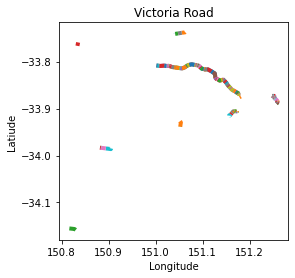

In [63]:
def plot_streets(streets, title, figsize, linewidth):
    # Getting a list of all colours, so we can see each victoria road separatley
    colour_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

    fig, ax = plt.subplots()
    streets["geometry"].plot(linewidth=linewidth,
                             color=[colour_list[r%len(colour_list)] for r in range(len(streets))],
                             figsize=figsize,
                             ax=ax)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latiude")

    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latiude")

    ax.set_title("Victoria Road")

victoria_road = streets[streets["name"] == "victoria road"]
plot_streets(victoria_road, "Victoria Road", (10,5), 4)


Oh. See that long multicoloured line? That is the major artery Victoria road. Its definitley one 20km long street, not 70 odd small streets. What is hapepening here is that OSM doesn't really care if streets are one long street or not - it is more concerned with what paths exist between differnt intersections. What we are seeing is that there are 197 segments of Victoria Road in Sydney. Not 197 individual victoria roads.

Anzac Parade highlights another problems:

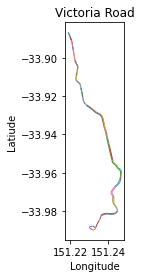

In [64]:
anzac_parade = streets[streets["name"] == "anzac parade"]
plot_streets(anzac_parade, "Anzac Parade", (10,20), linewidth=1)

On dual carriage ways, each direction is its own road segment and there can be quite a gap between them. Also road segments don't line up perfectly. Yet these should be one road. I need a method to merge them together

# Merging Streets
I am going to use Anzac Parade as my initial test case for testing to merge streets. It is a good test case as there is only one Anzac Parade in Sydney, parts are a dual carriage way  and there are some gaps in between road segments. 

Conveniently, the python package shapely provides a linemerge function that finds the contigous parts of an array of linestrings and produces a multiline string. Testing, using Anzac Parade:

In [30]:
anzac_merge = shapely.ops.linemerge(anzac_parade["geometry"].values)

Plotting the merged street, we can still see it isn't great. 

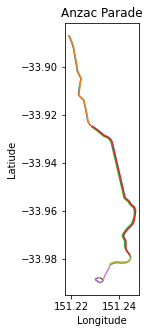

In [33]:
# fig, ax = plt.subplots(figsize=(10,20))
fig, ax = plt.subplots(figsize=(10,5))
ax.get_xaxis().get_major_formatter().set_useOffset(False)

ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latiude")
ax.set_title("Anzac Parade")
for l, line in enumerate(anzac_merge):
    gpd.GeoDataFrame(index = [l], geometry = [line]).plot(color=colour_list[l%9], ax = ax)


Definitely an improvement, but line merge doesn't handle the gaps in the road. This is because the linemerge function is strict about what contiguous means - the streets need to actually overlap, not just be close enough. 

At this point I tried a few different approaches. Most were variants on
* Get streets with the same name
* Merge streets that are "close enough"

What is shown below is the result works and is in general fast enough (although I'm sure could be optimised.)

In [48]:
# First step: use line merge to get all the obvious ones together, then run the other function over everything
# Get each point for line, put buffer around

def merge_lines(streets):
    street_name = streets["name"].iloc[0]
    streets_merged = streets.copy()
    
    distance = .001 # 1 = 100km, .1 = 10km, .01 = 1km
    
    # create a distance matrix
    dist = streets_merged["geometry"].apply(lambda x: streets_merged["geometry"].apply(lambda y: x.distance(y)))
    
    new_df = []
    used = []
    for street in streets.index:
        
        # Check if street has been added
        if street in used:
            continue
        
        # Put all streets < distance away from this street on a stack
        curr_street = dist.loc[street]
        close_seg = curr_street[curr_street < distance]

        one_street = [val for val in close_seg.index.values]

        i = 0
        while True:
            try:
                # pop item from stack
                next_street = one_street[i]
                i = i + 1
                
                # push all streets that are within distance and haven't already been added
                curr_street = dist.loc[next_street]
                close_seg = curr_street[curr_street < distance]
                
                new_streets = [st for st in close_seg.index if st not in one_street]
  
                one_street.extend(new_streets)
            except IndexError:
                break
            
        used.extend(one_street)
        
        # Make a new row for a DF
        new_point = pd.Series(data={"access": [streets.loc[id]["access"] for id in one_street],
                                    "bridge": [streets.loc[id]["bridge"] for id in one_street],
                                     "class": [streets.loc[id]["class"] for id in one_street],
                                     "geometry": [streets.loc[id]["geometry"] for id in one_street],
                                     "id": [streets.loc[id]["id"]  for id in one_street],
                                     "name": street_name,
                                     "oneway": [streets.loc[id]["oneway"] for id in one_street],
                                     "osm_id": [streets.loc[id]["osm_id"]  for id in one_street],
                                     "ref": [streets.loc[id]["ref"] for id in one_street],
                                     "service":[streets.loc[id]["service"] for id in one_street],
                                     "tunnel":[streets.loc[id]["tunnel"]  for id in one_street],
                                     "type":[streets.loc[id]["type"] for id in one_street],
                                     "z_order":[streets.loc[id]["z_order"] for id in one_street] })
        new_df.append(new_point)
    
    return pd.DataFrame(new_df)

Checking both Victoria Road and Anzac Parade:

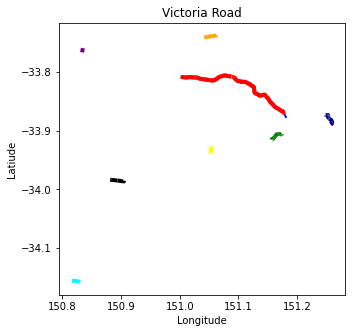

In [49]:
victoria_road_merge = merge_lines(victoria_road)

fig, ax = plt.subplots(figsize=(10,5))

ax.get_xaxis().get_major_formatter().set_useOffset(False)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latiude")
ax.set_title("Anzac Parade")
ax.set_title("Victoria Road")


for l, line in enumerate(victoria_road_merge['geometry']):
    gpd.GeoDataFrame(index = [k for k in enumerate(line)], geometry = line).plot(color = colours[l%9],
                                                                                 ax = ax,
                                                                                 linewidth=4)

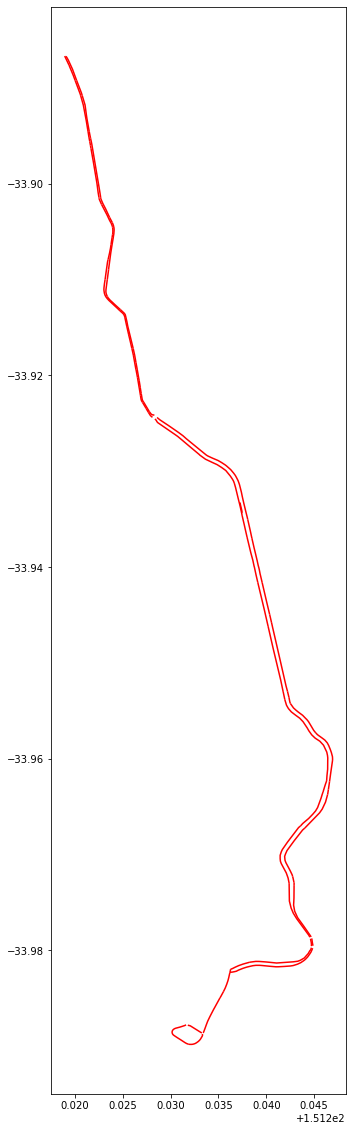

In [50]:
anzac_merge = merge_lines(anzac_parade)
fig, ax = plt.subplots(figsize=(10,20))
for l, line in enumerate(anzac_merge['geometry']):
    gpd.GeoDataFrame(index = [k for k in enumerate(line)], geometry = line).plot(color = colours[l%9], ax = ax)


And they work! Let's merge all of Sydney's streets. 

In [38]:
merge_street = streets.groupby('name').apply(merge_lines).reset_index(drop=True)


# So what is the most common street name in Sydney?
Now that we have merged the streets together we should be able to answer this question

In [56]:

merge_street.reset_index(drop=True).groupby("name").count()["id"].sort_values(ascending = False).head(10)

name
short street       46
george street      45
william street     44
john street        38
church street      37
king street        36
arthur street      34
victoria street    34
albert street      34
charles street     33
Name: id, dtype: int64

This looks much better! Nothing jumps out as "wrong". If we plot the first few:

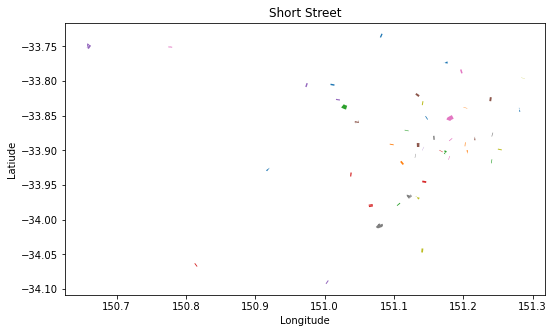

In [89]:

def plot_merge_streets(street, title):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.get_xaxis().get_major_formatter().set_useOffset(False)

    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latiude")
    ax.set_title(title)
    for l, line in enumerate(street['geometry'].values):
        gpd.GeoDataFrame(index = [l]*len(line), geometry = [seg for seg in line]).plot(color=colour_list[l%9], ax = ax, linewidth=4)

plot_merge_streets(merge_street[merge_street['name']=='short street'], "Short Street")


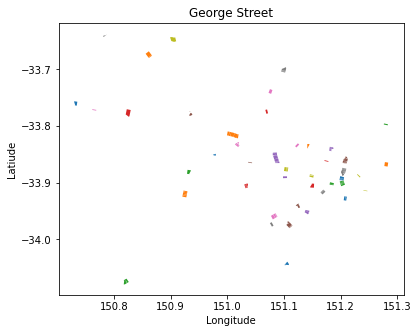

In [90]:
plot_merge_streets(merge_street[merge_street["name"] == "george street"], "George Street")


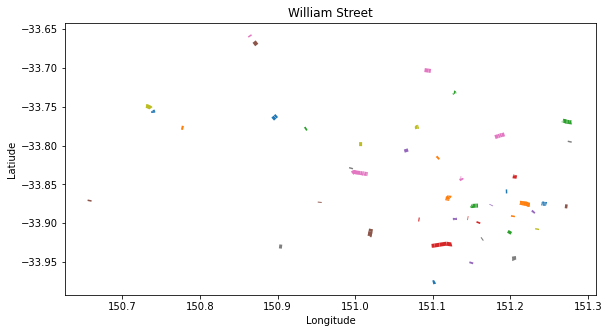

In [91]:
plot_merge_streets(merge_street[merge_street["name"] == "william street"], "William Street")


No problems there. There is one caveat with this approach. Have a look at Pitt Street:

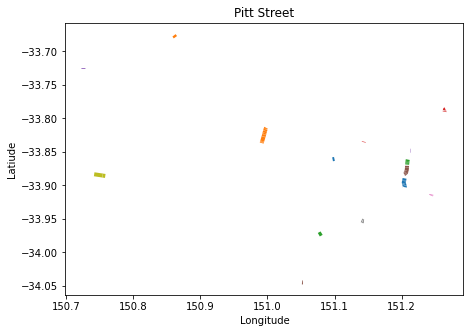

In [92]:
plot_merge_streets(merge_street[merge_street["name"] == "pitt street"], "Pitt Street")


There is a Pitt street in the Sydney CBD - which is the green, purple/brown and blue steets on the mid-right. This isn't a case of the merging failing though. Pitt street is interrupted by a Pitt Street mall, a pedestrian mall that we didn't count as a street. It is also interrupted by Central Station, which is definitely not a street. Whether the CBD Pitt Street should be counted as one street or three is a bit of a judgement call. I decided to just leave it as it is. I can always fix it later.

Next step: what is a street name?
